### Visualizing convnet filters

In [7]:
#importing weights from VGG16
from keras.applications import VGG16
from keras import backend as K
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

In [3]:
#utility function to convert tensor in to a valid image
def deprocess_image(x):
    #Normalizes the tensor: centers on 0, std is 0.1
    x -= x.mean()
    x /= (x.std()+ 1e-5)
    x *= 0.1

    #clips to [0,1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    #converts to an RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [25]:
#Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=150):
    #Build a loss function that maximizes the activation of the nth filter of the specific layer
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    #compute the gradient of the input picture with regards to the loss
    grads = K.gradients(loss, model.input)[0]
    
    #normalization trick: normalizes the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    #returns the loss and grads given the input image
    iterate = K.function([model.input], [loss,grads])
    
    #starts from gray scale image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    #run gradient ascent for 40 steps
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    
    return deprocess_image(img)

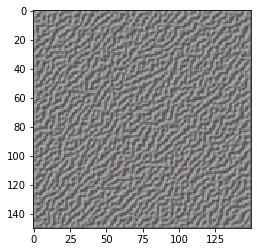

In [27]:
import matplotlib.pyplot as plt
fig = generate_pattern('block1_conv1', 0)
plt.imshow(fig)

In [30]:
layer_name = 'block1_conv1'
size = 32
margin = 1

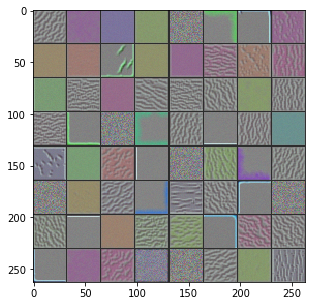

In [31]:
#generating a grid of all filter response patterns in a layer

#empty black image to store filter images
results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))

#iterate over rows of the result grid
for i in range(8):
    #iterate over columns of the result grid
    for j in range(8):
        
        #generate the pattern for filter i+(j*8) in the layer
        filter_img = generate_pattern(layer_name, i+(j*8), size=size)
     
        #put the result in the square(i,j) of the results grid
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
#display the result grid
plt.figure(figsize=(5,5))
plt.imshow(deprocess_image(results))
